# Time Serie

https://www.youtube.com/watch?v=vV12dGe_Fho

https://www.kaggle.com/code/robikscube/time-series-forecasting-with-machine-learning-yt

## Libraries

In [1]:
#!pip install xgboost

In [2]:
%matplotlib inline

import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.impute import KNNImputer

from sklearn.preprocessing import StandardScaler

from sklearn.preprocessing import Normalizer 

from sklearn.metrics import silhouette_score as ss

import plotly.express as px

import itertools

from matplotlib import gridspec 

from sklearn.datasets import make_blobs

from seaborn import scatterplot as scatter

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 

from statsmodels.tsa.arima_model import ARIMA

import statsmodels.api as sm

import statsmodels.tsa.api as smtsa

from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.tsa.holtwinters import ExponentialSmoothing

from statsmodels.tsa.stattools import adfuller

from tqdm import tqdm_notebook

from itertools import product

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

from sklearn.metrics import median_absolute_error, mean_squared_log_error

import xgboost as xgb
from sklearn.metrics import mean_squared_error

from matplotlib.pylab import rcParams

In [3]:
import pandas as pd

# Read the CSV file and set the "Date" column as the index
raia = pd.read_csv("RADL3.SA.csv", usecols=["Date", "Close"], index_col="Date", parse_dates=True)

# Display the DataFrame with the index set to "Date" and only the "Close" column
print(raia)


                Close
Date                 
2020-01-02  22.082691
2020-01-03  21.590384
2020-01-06  21.165384
2020-01-07  20.875000
2020-01-08  21.153847
...               ...
2023-12-21  29.020000
2023-12-22  28.889999
2023-12-26  29.420000
2023-12-27  29.160000
2023-12-28  29.400000

[993 rows x 1 columns]


<Axes: xlabel='Date'>

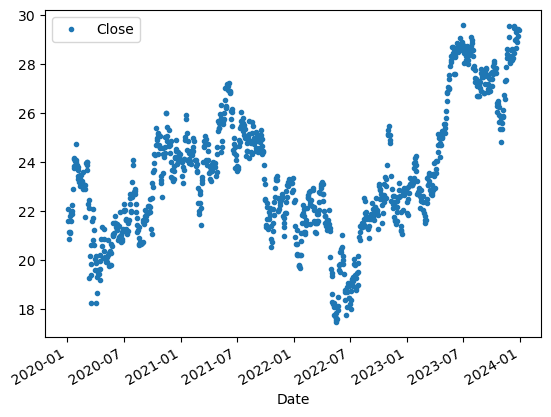

In [4]:
raia.plot(style = ".")

## Train Test Split

In [5]:
train = raia.loc[raia.index < "01-01-2023"]
test = raia.loc[raia.index >= "01-01-2023"]

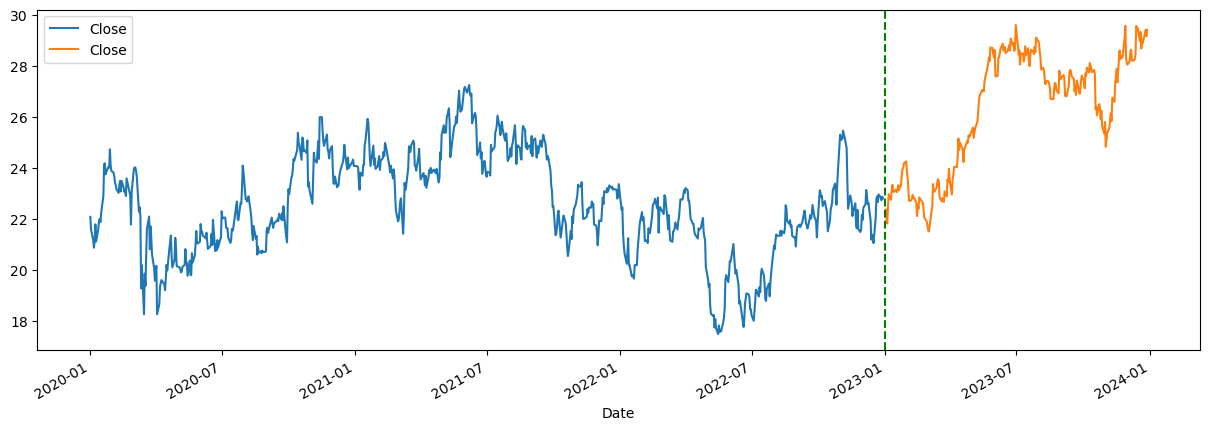

In [7]:
fig, ax = plt.subplots(figsize = (15, 5))

train.plot(ax = ax, label = "Training Set")
test.plot(ax = ax, label = "Test Set")

ax.axvline("01-01-2023", color = "green", ls = "--")

plt.show()

<Axes: xlabel='Date'>

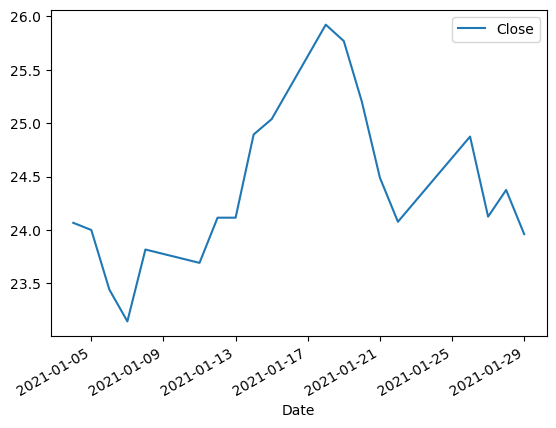

In [8]:
raia.loc[(raia.index > "01-01-2021") & (raia.index < "02-01-2021")].plot()

## Feature Creation

https://pandas.pydata.org/docs/reference/api/pandas.to_datetime.html

https://pandas.pydata.org/docs/user_guide/timeseries.html

In [9]:
def create_features(raia):
    """
    Create time series features 
    """
    raia = raia.copy()
    raia["quarter"] = raia.index.quarter
    raia["month"] = raia.index.month
    raia["year"] = raia.index.year

    return(raia)

In [10]:
raia = create_features(raia)

In [11]:
train = create_features(train)
test = create_features(test)


FEATURES = ['quarter', 'month', 'year']
TARGET = 'Close'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

## Visualise our features / target relationship

<Axes: xlabel='year', ylabel='Close'>

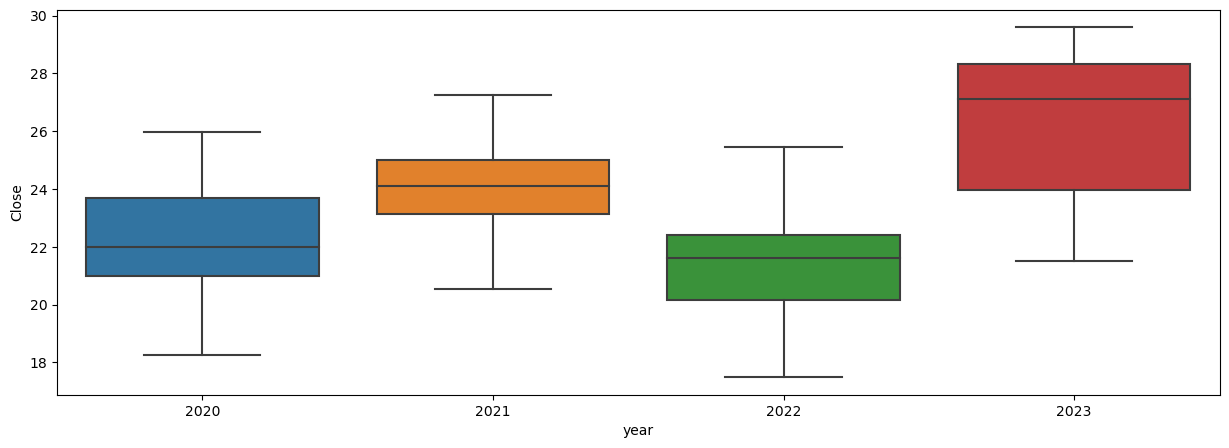

In [12]:
fig, ax = plt.subplots(figsize = (15, 5))
sns.boxplot(data = raia, x = "year", y = "Close")

<Axes: xlabel='month', ylabel='Close'>

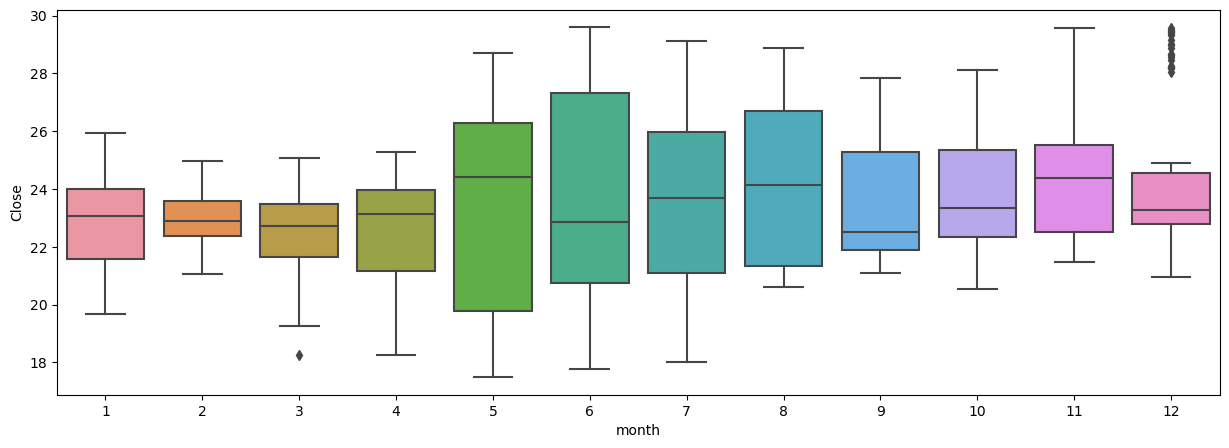

In [13]:
fig, ax = plt.subplots(figsize = (15, 5))
sns.boxplot(data = raia, x = "month", y = "Close")

## Create our model

In [13]:
reg = xgb.XGBRegressor(n_estimators = 1000, early_stopping_rounds = 50,
                      learning_rate = 0.001)
reg.fit(X_train, y_train,
       eval_set = [(X_train, y_train), (X_test, y_test)],
       verbose = 100)

[0]	validation_0-rmse:1.65520	validation_1-rmse:3.19522
[89]	validation_0-rmse:1.55596	validation_1-rmse:3.19543


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.001, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## Feature Importance

In [14]:
fi = pd.DataFrame(data = reg.feature_importances_,
             index = reg.feature_names_in_, 
                 columns = ["importance"])

In [15]:
fi

,importance
quarter,0.87858
month,0.12142
year,0.00000


<Axes: >

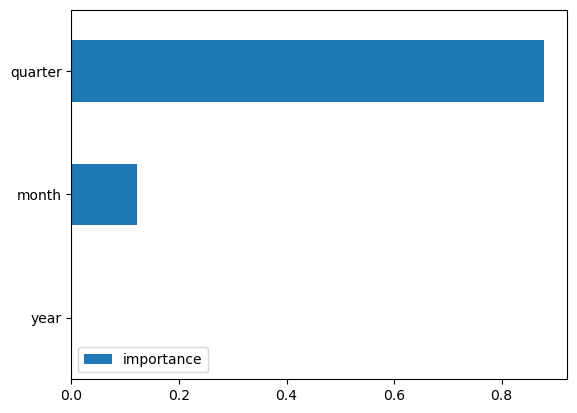

In [16]:
fi.sort_values("importance").plot(kind = "barh")

## Forecast on Test

In [17]:
test["prediction"] = reg.predict(X_test)

In [18]:
raia.merge(test[["prediction"]], how = "left", left_index = True, right_index = True)

,Close,quarter,month,year,prediction
Date,,,,,
2020-01-02,22.082691,1,1,2020,NaN
2020-01-03,21.590384,1,1,2020,NaN
2020-01-06,21.165384,1,1,2020,NaN
2020-01-07,20.875000,1,1,2020,NaN
2020-01-08,21.153847,1,1,2020,NaN
...,...,...,...,...,...
2023-12-21,29.020000,4,12,2023,22.317392
2023-12-22,28.889999,4,12,2023,22.317392
2023-12-26,29.420000,4,12,2023,22.317392


ax = raia[["Close"]].plot()
raia["prediction"].plot(ax = ax, style = ".")

# Time Series Edureka

https://www.youtube.com/watch?v=e8Yw4alG16Q

In [19]:
import pandas as pd

# Read the CSV file and set the "Date" column as the index
r = pd.read_csv("RADL3.SA.csv", usecols=["Date", "Close"], index_col="Date", parse_dates=True)

# Display the DataFrame with the index set to "Date" and only the "Close" column
r.head()


,Close
Date,
2020-01-02,22.082691
2020-01-03,21.590384
2020-01-06,21.165384
2020-01-07,20.875000
2020-01-08,21.153847


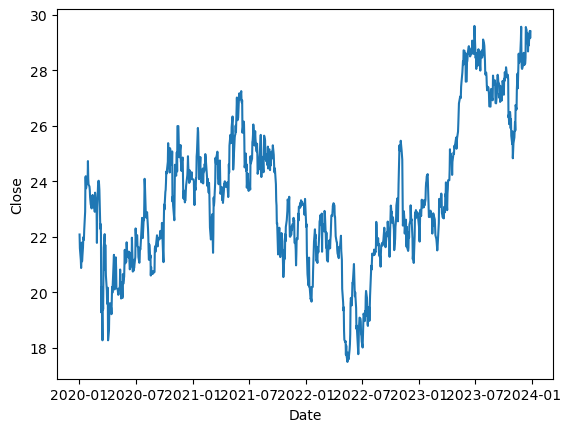

In [20]:
plt.xlabel("Date")
plt.ylabel("Close")
plt.plot(r)

The trend is going up over the years. It had a decrease before the pandemic and a huge increase after 

It is not stationary because the mean is not constant 

air_passengers['1950-01-05':'1951-02-17']

rolmean = r["2020-01-01" : "2024-01-01"].rolling(window = 12).mean()

rolstd = r["2020-01-01" : "2024-01-01"].rolling(window = 12).std()

print(rolmean, rolstd)

In [21]:
rolmean = r.rolling(window = 12).mean()

rolstd = r.rolling(window = 12).std()

print(rolmean, rolstd)

                Close
Date                 
2020-01-02        NaN
2020-01-03        NaN
2020-01-06        NaN
2020-01-07        NaN
2020-01-08        NaN
...               ...
2023-12-21  28.857500
2023-12-22  28.879167
2023-12-26  28.977500
2023-12-27  29.058333
2023-12-28  29.154167

[993 rows x 1 columns]                Close
Date                
2020-01-02       NaN
2020-01-03       NaN
2020-01-06       NaN
2020-01-07       NaN
2020-01-08       NaN
...              ...
2023-12-21  0.521242
2023-12-22  0.516306
2023-12-26  0.495454
2023-12-27  0.430113
2023-12-28  0.355232

[993 rows x 1 columns]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


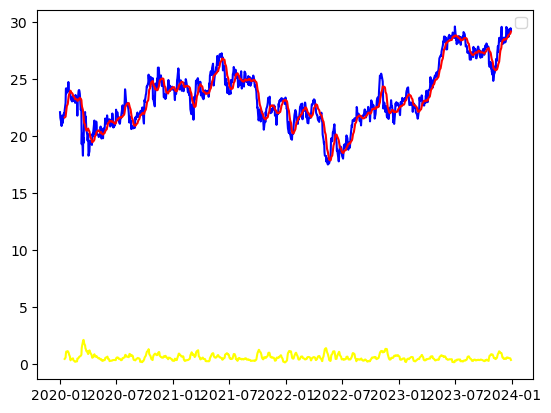

In [22]:
orig = plt.plot(r, color = "blue")
mean = plt.plot(rolmean, color = "red")
std = plt.plot(rolstd, color = "yellow")
plt.legend(loc = "best")
plt.show(block = False)

In [23]:
print("Results of Dickey Fuller Test:")

dftest = adfuller(r["Close"], autolag = "AIC")

dfoutput = pd.Series(dftest[0:4], index = ["Test Statistic", "p-value", 
                                          "#Lags Used", "# of Obs used"])

for key, value in dftest[4].items():
    dfoutput["Critical Value (%s)"%key] = value
    

print(dfoutput)

Results of Dickey Fuller Test:
Test Statistic           -2.095733
p-value                   0.246234
#Lags Used                1.000000
# of Obs used           991.000000
Critical Value (1%)      -3.436966
Critical Value (5%)      -2.864461
Critical Value (10%)     -2.568325
dtype: float64


The results of the Dickey-Fuller test are as follows:

Test Statistic: -0.225653
p-value: 0.935394
#Lags Used: 21
Number of Observations Used: 2955
Critical Value (1%): -3.432565
Critical Value (5%): -2.862519
Critical Value (10%): -2.567291
Based on these results, we can interpret the test as follows:

The test statistic is less than the critical values at all significance levels.
The p-value is greater than 0.05, indicating that we fail to reject the null hypothesis.
Therefore, we conclude that the data is non-stationary.

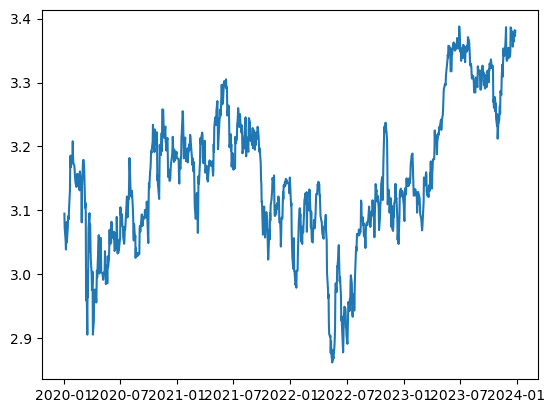

In [24]:
r_logScale = np.log(r)
plt.plot(r_logScale)

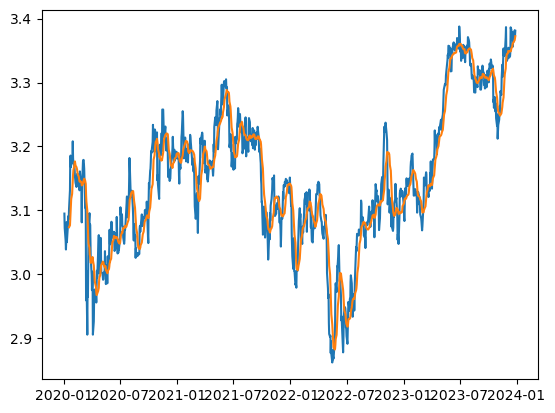

In [25]:
m_avarage = r_logScale.rolling(window = 12).mean()
m_std = r_logScale.rolling(window = 12).std()

plt.plot(r_logScale)
plt.plot(m_avarage)

In [26]:
log_m_avg = r_logScale - m_avarage

log_m_avg.dropna(inplace = True)

log_m_avg.head()

,Close
Date,
2020-01-17,0.028715
2020-01-20,0.054885
2020-01-21,0.097860
2020-01-22,0.088744
2020-01-23,0.059863


In [27]:
def test_stationarity(timeseries):
    
    rolmean = timeseries.rolling(window = 12).mean()
    rolstd = timeseries.rolling(window = 12).std()
    
    orig = plt.plot(timeseries, color = "blue")
    mean = plt.plot(rolmean, color = "red")
    std = plt.plot(rolstd, color = "yellow")
    plt.legend(loc = "best")
    plt.show(block = False)
    
    print("Results of Dickey Fuller Test:")
    dftest = adfuller(r["Close"], autolag = "AIC")
    dfoutput = pd.Series(dftest[0:4], index = ["Test Statistic", "p-value", "#Lags Used", "# of Obs used"])
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)"%key] = value
    print(dfoutput)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


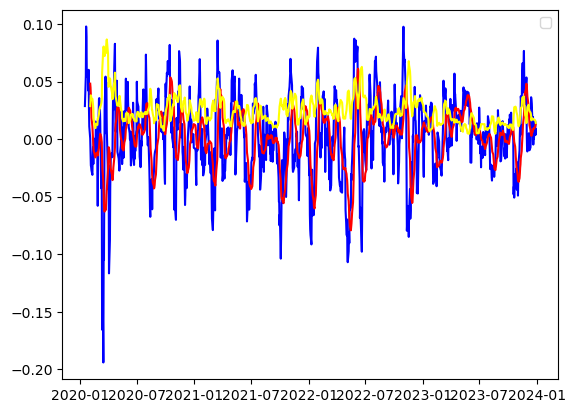

Results of Dickey Fuller Test:
Test Statistic           -2.095733
p-value                   0.246234
#Lags Used                1.000000
# of Obs used           991.000000
Critical Value (1%)      -3.436966
Critical Value (5%)      -2.864461
Critical Value (10%)     -2.568325
dtype: float64


In [28]:
test_stationarity(log_m_avg)

The Dickey-Fuller test is often used to determine whether a time series is stationary. Here's how to interpret the results:

Test Statistic: This is the Dickey-Fuller test statistic. It's a negative number. The more negative it is, the stronger the evidence against the null hypothesis (the null hypothesis being that the time series is non-stationary). In this case, the test statistic is -2.095733.
p-value: This is the p-value for the hypothesis test. If the p-value is small (typically less than 0.05), we reject the null hypothesis and conclude that the time series is stationary. If the p-value is large, we fail to reject the null hypothesis. In this case, the p-value is 0.246234, which is greater than 0.05. Therefore, we fail to reject the null hypothesis.
#Lags Used: This is the number of lags used in the regression when computing the test statistic. In this case, 1 lag is used.
# of Obs used: This is the number of observations used in the analysis. In this case, 991 observations are used.
Critical Values: These are the critical values for the test statistic at various significance levels (1%, 5%, and 10%). If the test statistic is less than these critical values, we reject the null hypothesis. Otherwise, we fail to reject the null hypothesis.
Based on the results, since the p-value is greater than 0.05, we fail to reject the null hypothesis. Therefore, we do not have enough evidence to conclude that the time series is stationary.

https://www.youtube.com/watch?v=e8Yw4alG16Q

parei no 26m

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA


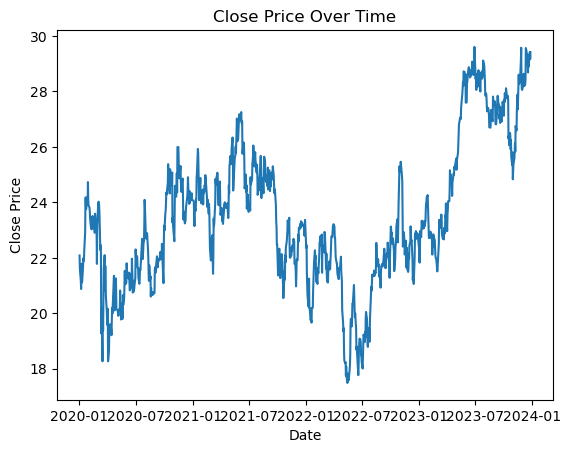

In [30]:
plt.plot(raia['Close'])
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Close Price Over Time')
plt.show()


In [31]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(raia['Close'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])


ADF Statistic: -2.095732594176349
p-value: 0.24623400560329617


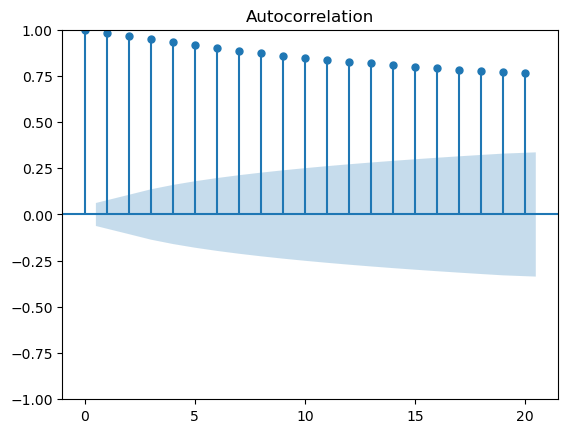

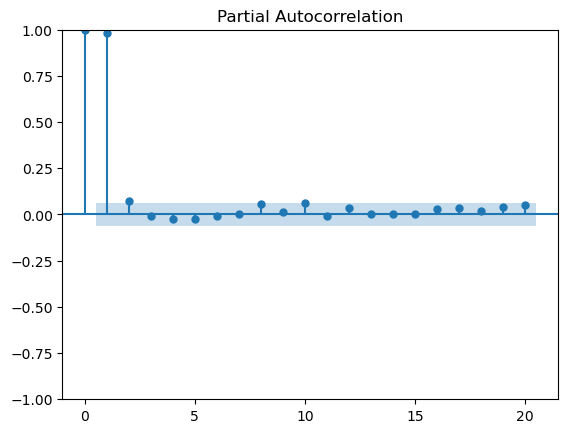

In [32]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(raia['Close'], lags=20)
plot_pacf(raia['Close'], lags=20)
plt.show()


In [33]:
p = 2  # order of the autoregressive (AR) term
d = 1  # degree of differencing
q = 20  # order of the moving average (MA) term

model = ARIMA(raia['Close'], order=(p, d, q))
fitted_model = model.fit()


/Users/izaiaszacca/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/izaiaszacca/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/izaiaszacca/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/izaiaszacca/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("

In [34]:
print(fitted_model.summary())


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  993
Model:                ARIMA(2, 1, 20)   Log Likelihood                -624.913
Date:                Sun, 21 Apr 2024   AIC                           1295.827
Time:                        17:38:03   BIC                           1408.520
Sample:                             0   HQIC                          1338.675
                                - 993                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8718      0.215      4.049      0.000       0.450       1.294
ar.L2         -0.6875      0.210     -3.269      0.001      -1.100      -0.275
ma.L1         -0.9802      0.219     -4.479      0.0

In [35]:
forecast = fitted_model.forecast(steps= 12)  # Specify the number of steps to forecast


/Users/izaiaszacca/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/izaiaszacca/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


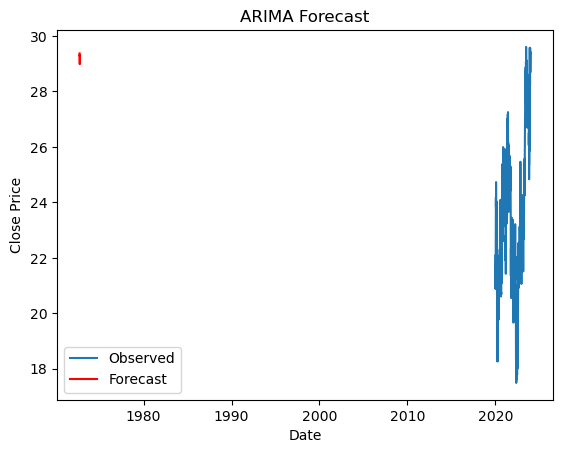

In [36]:
plt.plot(raia['Close'], label='Observed')
plt.plot(forecast, label='Forecast', color='red')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('ARIMA Forecast')
plt.legend()
plt.show()
